In [35]:
import json
import os
import matplotlib.pyplot as plt

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.mixed_precision import set_global_policy

# Enable mixed precision training
set_global_policy('mixed_float16')

# Define constants
BATCH_SIZE = 32
IMG_SIZE = 32
NUM_CLASSES = 10  # Number of classes to identify
NUM_EPOCHS = 100  # Increase number of epochs
LEARNING_RATE = 0.00005  # Lower learning rate for fine-tuning

# Define directories
train_dirs = ['./dataset/train/train1', './dataset/train/train2',
              './dataset/train/train3', './dataset/train/train5']
validation_dir = './dataset/validation'
test_dir = './dataset/test'

In [36]:
# Preprocessing the data
# Create ImageDataGenerator for training, validation, and test data with only rescaling
datagen = ImageDataGenerator(rescale=1./255)


# Create multiple train generators
train_generators = [datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical') for train_dir in train_dirs]

# Custom generator to merge multiple directories and repeat
def combined_generator(generators):
    while True:
        for generator in generators:
            for batch in generator:
                yield batch


train_generator = combined_generator(train_generators)

# Validation and test generators
validation_generator = datagen.flow_from_directory(
    validation_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical')



Found 10000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.


In [37]:
# Define the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])


In [38]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),  # Reduce learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [39]:
# Define callbacks
os.makedirs('outputs', exist_ok=True)
checkpoint = ModelCheckpoint("models/best_from_scratch.keras",
                             monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(
    monitor='val_loss', patience=7, restore_best_weights=True) 
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=2, min_lr=1e-7, verbose=1)
csv_logger = CSVLogger('outputs/from_scratch_training_log.csv', separator=',', append=False)

In [40]:
# Calculate steps per epoch
steps_per_epoch = sum([gen.samples // BATCH_SIZE for gen in train_generators])
validation_steps = validation_generator.samples // BATCH_SIZE

In [41]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=NUM_EPOCHS,  # Increase number of epochs
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[checkpoint, early_stopping, reduce_lr, csv_logger]
)

Epoch 1/100
1246/1248 [============================>.] - ETA: 0s - loss: 2.1302 - accuracy: 0.2007
Epoch 1: val_accuracy improved from -inf to 0.30078, saving model to models\best_from_scratch.keras
1248/1248 [==============================] - 18s 13ms/step - loss: 2.1301 - accuracy: 0.2009 - val_loss: 1.9625 - val_accuracy: 0.3008 - lr: 5.0000e-05
Epoch 2/100
1247/1248 [============================>.] - ETA: 0s - loss: 1.8487 - accuracy: 0.3152
Epoch 2: val_accuracy improved from 0.30078 to 0.34275, saving model to models\best_from_scratch.keras
1248/1248 [==============================] - 16s 13ms/step - loss: 1.8486 - accuracy: 0.3153 - val_loss: 1.8245 - val_accuracy: 0.3427 - lr: 5.0000e-05
Epoch 3/100
1246/1248 [============================>.] - ETA: 0s - loss: 1.7339 - accuracy: 0.3618
Epoch 3: val_accuracy improved from 0.34275 to 0.39533, saving model to models\best_from_scratch.keras
1248/1248 [==============================] - 16s 13ms/step - loss: 1.7339 - accuracy: 0.3618 

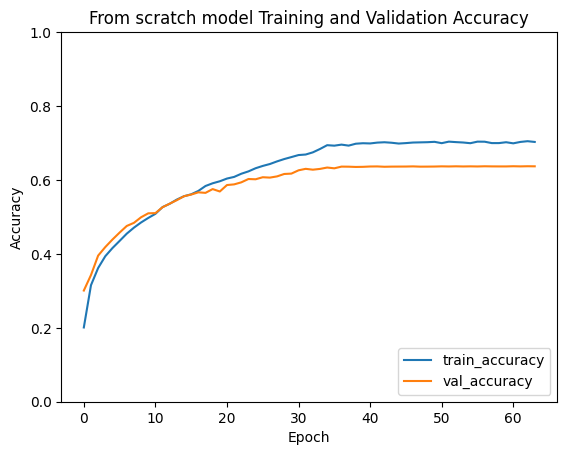

In [42]:
# Plot training history and save the plot
plt.figure()
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('From scratch model Training and Validation Accuracy')
plt.savefig('outputs/from_scratch_training_accuracy_plot.png')
plt.show()